# Neural Networks and Learning Course
----------------------------------------------------------
# Mushroom Recommender Projet
----------------------------------------------------------
# By Begum SARIGUZEL

#### Importing libraries

In [21]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import cufflinks as cf
import itertools
from collections import Counter
import scipy.stats as ss
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

#### Loading the data

In [2]:
mushroom = pd.read_csv("mushrooms.csv")

#### Is the data balanced?

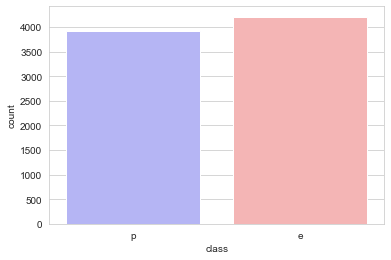

In [3]:
sns.set_style("whitegrid")
sns_fig = sns.countplot(x="class", data=mushroom, palette="bwr")
fig = sns_fig.get_figure()
fig.savefig("balance.png")

#### Visualization of distribution of all categories in each feature

In [5]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [6]:
for col in mushroom.columns[1:]:
    pd.crosstab(mushroom[col], mushroom['class'], normalize=True).iplot(kind='bar', colorscale='Pastel1',title ='Types of ' + col)

#### Label Encoding of data

In [10]:
labelen = LabelEncoder()
mushroom_encode = mushroom[mushroom.columns].apply(lambda col: labelen.fit_transform(col))

#### Calculation of association between each feature
I computed uncertainty coeffient which gives associations between categorical features. It is based on the conditional entropy between two discrete random variables x and y and it calculates the conditional entropy and then we can calculate the degree of association between these two variables. Similarly to the correlation the output is in the range of [0,1], where 0 means no association and 1 is full association.

In [13]:
def conditional_entropy(x, y):
    """Calculates the conditional entropy of x given y: S(x|y)

    Parameters
    ----------
    x,y : array-like, int-encoded categorical value arrays
    
    Returns
    -------
    entropy : float
    
    See Also
    --------
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    
    """
    y=y.astype(np.int64)
    y_counter = np.bincount(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = y_counter.sum()
    entropy = 0.0
    for k,v in xy_counter.items():
        p_xy = v / total_occurrences
        p_y = y_counter[k[1]] / total_occurrences
        entropy += p_xy * np.log(p_y/p_xy)
    return entropy
def theils_u(x, y):
    """Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
   
    This is the uncertainty of x given y: value is on the range of [0,1] 
    - where 0 means y provides no information about x, 
    and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    
    Parameters
    ----------
    x,y : array-like, int-encoded categorical value arrays
    
    Returns
    -------
    uncertainity coefficent : float between [0,1]
    
    See Also
    --------
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    """
    x=x.astype(np.int64)
    s_xy = conditional_entropy(x,y)
    x_counter = np.bincount(x)
    total_occurrences = x_counter.sum()
    p_x = x_counter/total_occurrences
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    return (s_x - s_xy) / s_x

def catcorr(data, method='theils'):
    """ Compute categorical correlations using uncertainty coefficients (Theil's U) 
    
    Parameters
    ----------
    data : pandas.DataFrame 
        dataset used to compute correlations 
    method - str, ['theils' | 'cramers']
        method to calculate correlations, cramers is symmetric, theils is asymmetric
    
    Returns
    -------
        computed correlations : pandas.DataFrame
    """
   
    cols = data.columns
    clen = cols.size
    
    pairings = list(itertools.product(data.columns, repeat=2))
    theils_mat = np.reshape([theils_u(data[p[1]],data[p[0]]) for p in pairings],(clen,clen))
    return pd.DataFrame(theils_mat, index=cols, columns=cols)

#### Visualization of association results 

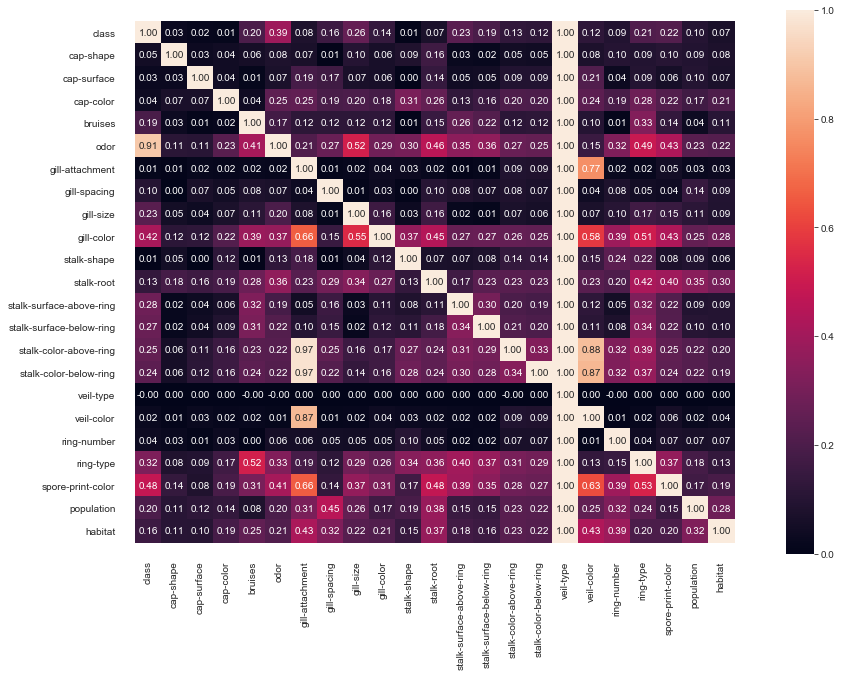

In [14]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
sns_plot = sns.heatmap(catcorr(mushroom_encode),0,1,ax=ax,annot=True,fmt="0.2f")
bottom, top = sns_plot.get_ylim()
left , right = sns_plot.get_xlim()
sns_plot.set_ylim(bottom + 1, top - 1)
sns_plot.set_xlim(left - 0.5, right + 0.5 )
#plt.savefig("heatmap.png")
plt.show()

#### Visualization of associations after removing veil-type feature which has 0 association with other features

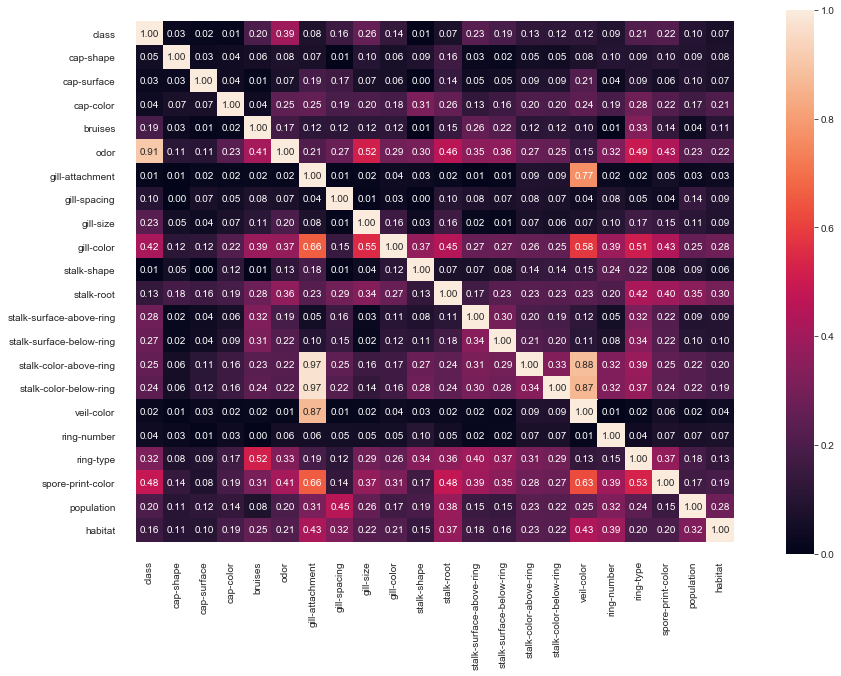

In [15]:
mushroom.drop(['veil-type'],axis=1,inplace=True)
mushroom_encode.drop(['veil-type'],axis=1,inplace=True)

fig, ax = plt.subplots(1,1, figsize=(14,10))
sns_plot = sns.heatmap(catcorr(mushroom_encode),0,1,ax=ax,annot=True,fmt="0.2f")
bottom, top = sns_plot.get_ylim()
left , right = sns_plot.get_xlim()
sns_plot.set_ylim(bottom + 1, top - 1)
sns_plot.set_xlim(left - 0.5, right + 0.5 )
#plt.savefig("heatmap2.png")
plt.show()

#### Visualization for 'odor' feature

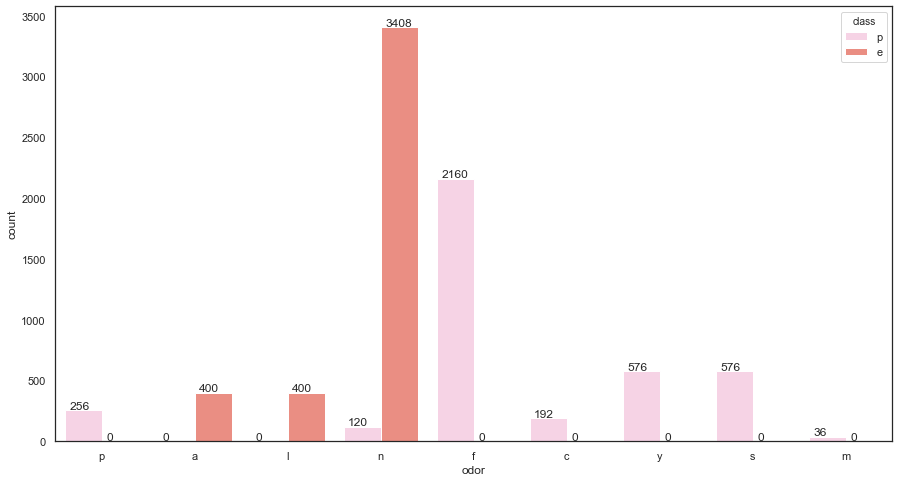

In [16]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style("white")
ax=sns.countplot(x='odor',hue='class',data=mushroom,palette='Set3_r')
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))

#### Splitting a part of data which contains only odorless mushrooms

In [18]:
no_odor = mushroom[mushroom['odor'].isin(['n'])]

#### Visualization of 'spore-print-color' for odorless mushrooms

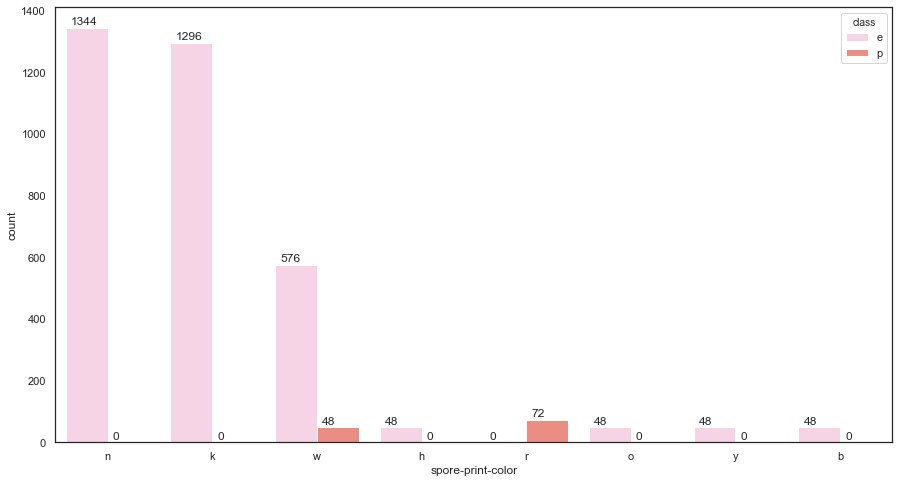

In [19]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style("white")

ax=sns.countplot(x='spore-print-color',hue='class',data=no_odor,palette='Set3_r')
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

#### One hot encoding

In [29]:
y = mushroom['class']
mushroom.drop(['class'],axis=1,inplace=True)
mushroom_preprocessed = pd.get_dummies(mushroom)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,s,w,w,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,s,w,w,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,s,w,w,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,s,w,w,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,s,w,w,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,s,s,o,o,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,...,s,s,o,o,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,...,s,s,o,o,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,...,s,k,w,w,w,o,e,w,v,l


In [30]:
labelen = LabelEncoder()
y = labelen.fit_transform(y)
y

array([1, 0, 0, ..., 0, 1, 0])

#### Normalization of the data & using PCA for 2 components

In [24]:
mushroom_normalized = StandardScaler().fit(mushroom_preprocessed).transform(mushroom_preprocessed)  

pca = PCA(n_components = 2).fit(mushroom_normalized)

mushroom_pca = pca.transform(mushroom_normalized)
mushroom.shape,mushroom_pca.shape

((8124, 22), (8124, 2))

In [25]:
def plot_labelled_scatter(X, y, class_labels, xlabel="", ylabel="", title=""):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA', '#AAAAAA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for l in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[l], label=class_labels[l]))
    plt.legend(handles=h)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title);
    
    plt.show()


#### Visualization of PCA for all data

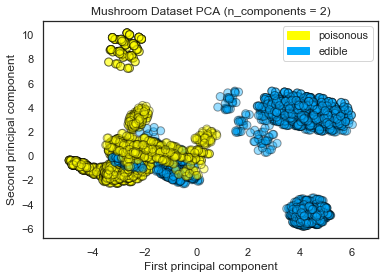

In [31]:
plot_labelled_scatter(mushroom_pca,
                      y,
                      ['poisonous', 'edible'],
                      xlabel='First principal component',
                      ylabel='Second principal component',
                      title='Mushroom Dataset PCA (n_components = 2)'
                     );

In [34]:
no_odor_w = no_odor[no_odor['spore-print-color'].isin(['w'])]
y_no_odor = no_odor_w['class']
no_odor_encode = no_odor_w[no_odor_w.columns].apply(lambda col: labelen.fit_transform(col))
y_no_odor = no_odor_encode['class']
no_odor_encode.drop(['class'],axis=1,inplace=True)
no_odor_w.drop(['class'],axis=1,inplace=True)
no_odor_preprocessed = pd.get_dummies(no_odor_w)

In [35]:
no_odor_normalized = StandardScaler().fit(no_odor_preprocessed).transform(no_odor_preprocessed)  

pca = PCA(n_components = 2).fit(no_odor_normalized)

no_odor_pca = pca.transform(no_odor_normalized)
no_odor_preprocessed.shape,no_odor_pca.shape

((624, 67), (624, 2))

#### Visualization of PCA for small data

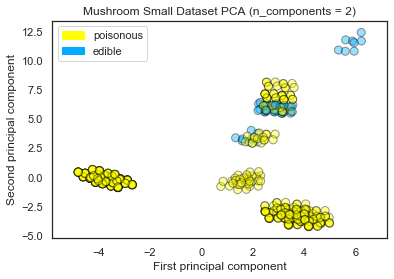

In [36]:
plot_labelled_scatter(no_odor_pca,
                      y_no_odor,
                      ['poisonous', 'edible'],
                      xlabel='First principal component',
                      ylabel='Second principal component',
                      title='Mushroom Small Dataset PCA (n_components = 2)'
                     );